In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot

sys.path.insert(0, '..')

from pybandstructure import *
import graphene as gr

In [2]:
#distances in nm, energies in eV
#################### band-structure parameters #######################################
k_cutoff = 1. #nm^-1 energies are accurate up to +-hv_F * k_cutoff
q_cutoff = 0.1
hv_F = 0.658  # \hbar v_F in eV*nm #1.0545919(80) x 10-27=\hbar [erg s]
n_sites = 60 # integer 
################### these parameters can be changed later ############################
density = 0. # nm^-2
temperature = 0.001 # eV k_B T
eta = 0.100 # eV energy broadening \hbar/tau 

In [3]:
reciprocal_lattice_basis = 2*k_cutoff * np.array([[1.,0.],
                                                  [0.,1.]], dtype = float)
point_group = Point_Group.trivial_group(space_dimension=2)
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                   point_group = point_group)
k_sample = Space_Sample.spherical_sample(basis_vectors = lattice_geometry.reciprocal_lattice_basis, 
                                         denominator = n_sites, 
                                         cut_off = k_cutoff )

In [4]:
class f_dirac:
    def __init__(self, hv, der = (0,0)):
        self.hv = hv
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return [self.hv * k[0], self.hv * k[1]]
        if self.der == (1,0):
            return self.hv * np.array([1,0])
        if self.der == (0,1):
            return self.hv * np.array([0,1])
        else:
            return np.array([0,0])

H = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                 coefficients = [f_dirac(hv = hv_F, der =(0,0))]) 
p_x = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                   coefficients =[f_dirac(hv = hv_F, der =(1,0))])
p_y = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                   coefficients = [f_dirac(hv = hv_F, der =(0,1))])

In [5]:
####################### Output folder ##################################
output_folder = 'test_output/single_layer_dirac'
file_name = '/single_layer_dirac.hdf5'
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass

band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 hamiltonian = H, 
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,
                                                 zero_filling = 1,
                                                 density = density,
                                                 temperature = temperature)

band_structure.compute_bands()
graphene = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)

100%|████████████████████████████████████████████████████████████████████████████| 2821/2821 [00:00<00:00, 9371.87it/s]


([[<matplotlib.lines.Line2D at 0x1e55067c348>],
 [[<matplotlib.lines.Line2D at 0x1e551e53a08>],
 [<matplotlib.lines.Line2D at 0x1e551e53f88>])

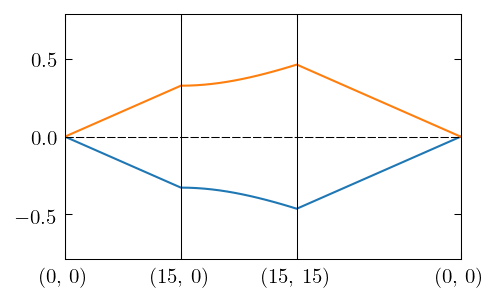

In [6]:
band_structure.plot(contour = [(0,0), (n_sites//4,0),(n_sites//4,n_sites//4),(0,0)])

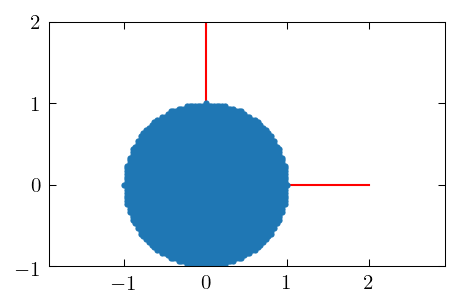

In [7]:
k_sample.plot()

In [8]:
n_0 = 4 * k_sample.integrate(np.ones([len(k_sample)]), axis =0) /(2. * np.pi)**2
alpha =10.
n_vals = np.linspace(-0.01,0.01,num = 11)
mu_vals = []
W_vals = []
for n in n_vals:
    band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 hamiltonian = H, 
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,
                                                 zero_filling = 1,
                                                 density = n,
                                                 temperature = temperature)
    sol = band_structure.compute_sc_bands(
                                      operators = [Momentum_Conserving_Operator(matrices = [pauli_matrix(0)],
                                      coefficients = [1.])], 
                                      transfer_function = lambda n :[alpha * (n[0]-n_0)], 
                                      initial_values = [0.], 
                                      eigvals = None, 
                                      options ={'method' : 'broyden1'})
    mu_vals.append(band_structure.chemical_potential)


 30%|██████████████████████▊                                                      | 834/2821 [00:00<00:00, 8257.67it/s]

     fun: array([0.])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.30758562])


 33%|█████████████████████████▏                                                   | 922/2821 [00:00<00:00, 9129.42it/s]

     fun: array([0.])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.30958562])


 31%|████████████████████████▏                                                    | 886/2821 [00:00<00:00, 8773.18it/s]

     fun: array([5.55111512e-17])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.31158562])


 63%|███████████████████████████████████████████████▌                            | 1765/2821 [00:00<00:00, 8838.50it/s]

     fun: array([-5.55111512e-17])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.31358562])


 32%|████████████████████████▉                                                    | 912/2821 [00:00<00:00, 9029.80it/s]

     fun: array([-1.66533454e-16])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.31558562])


 73%|██████████████████████████████████████████████████████▊                    | 2064/2821 [00:00<00:00, 10368.40it/s]

     fun: array([0.])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.31758562])


 64%|████████████████████████████████████████████████▊                           | 1812/2821 [00:00<00:00, 8926.09it/s]

     fun: array([-1.11022302e-16])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.31958562])


 32%|████████████████████████▊                                                    | 910/2821 [00:00<00:00, 9010.34it/s]

     fun: array([0.])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.32158562])


 61%|██████████████████████████████████████████████                              | 1711/2821 [00:00<00:00, 8231.61it/s]

     fun: array([5.55111512e-17])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.32358562])


 66%|██████████████████████████████████████████████████▏                         | 1861/2821 [00:00<00:00, 9329.86it/s]

     fun: array([5.55111512e-17])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.32558562])


 33%|█████████████████████████▍                                                   | 931/2821 [00:00<00:00, 9218.64it/s]

     fun: array([0.])
 message: 'A solution was found at the specified tolerance.'
     nit: 3
  status: 1
 success: True
       x: array([0.32758562])


100%|████████████████████████████████████████████████████████████████████████████| 2821/2821 [00:00<00:00, 9530.41it/s]


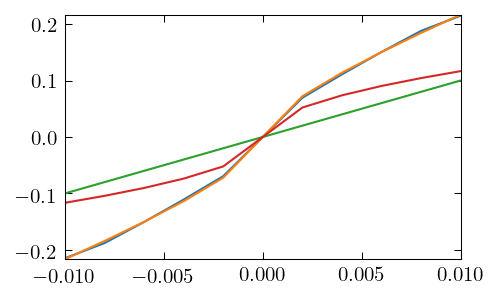

In [9]:
plt.plot(n_vals, mu_vals)

plt.plot(n_vals,hv_F * np.sign(n_vals) * np.sqrt(abs(n_vals)* np.pi)+alpha * n_vals)
plt.plot(n_vals,alpha * n_vals)
plt.plot(n_vals,hv_F * np.sign(n_vals) * np.sqrt(abs(n_vals)* np.pi))